2026-01-12 12:48:27.534347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Using device: cpu
PREPROCESSING COMPARISON STUDY
Comparing Minimal vs Aggressive Preprocessing Impact

STEP 1: LOAD DATA
Loaded: 33,396 reviews
Noisy reviews: 18,584 (55.6%)

Class distribution:
sentiment
positive    0.480926
negative    0.374805
neutral     0.144269
Name: proportion, dtype: float64

STEP 2: DEFINE PREPROCESSING FUNCTIONS
Minimal preprocessing: preserves typos, slang, punctuation, emoticons, stop words
Aggressive preprocessing: removes punctuation, stop words, normalizes repeated chars

Example comparison:
Original:    OMG!!! This place is sooooo AMAZING!!! Best food ever :)
Minimal:     omg!!! this place is sooooo amazing!!! best food ever :)
Aggressive:  omg place so amazing best food ever

STEP 3: APPLY BOTH PREPROCESSING STRATEGIES
Preprocessing applied to all reviews
Sample minimal:     why does it look like someone spit on my food? i had a normal transaction, everyone was chill and po
Sample aggressive:  why look like someone spit food normal transaction everyone

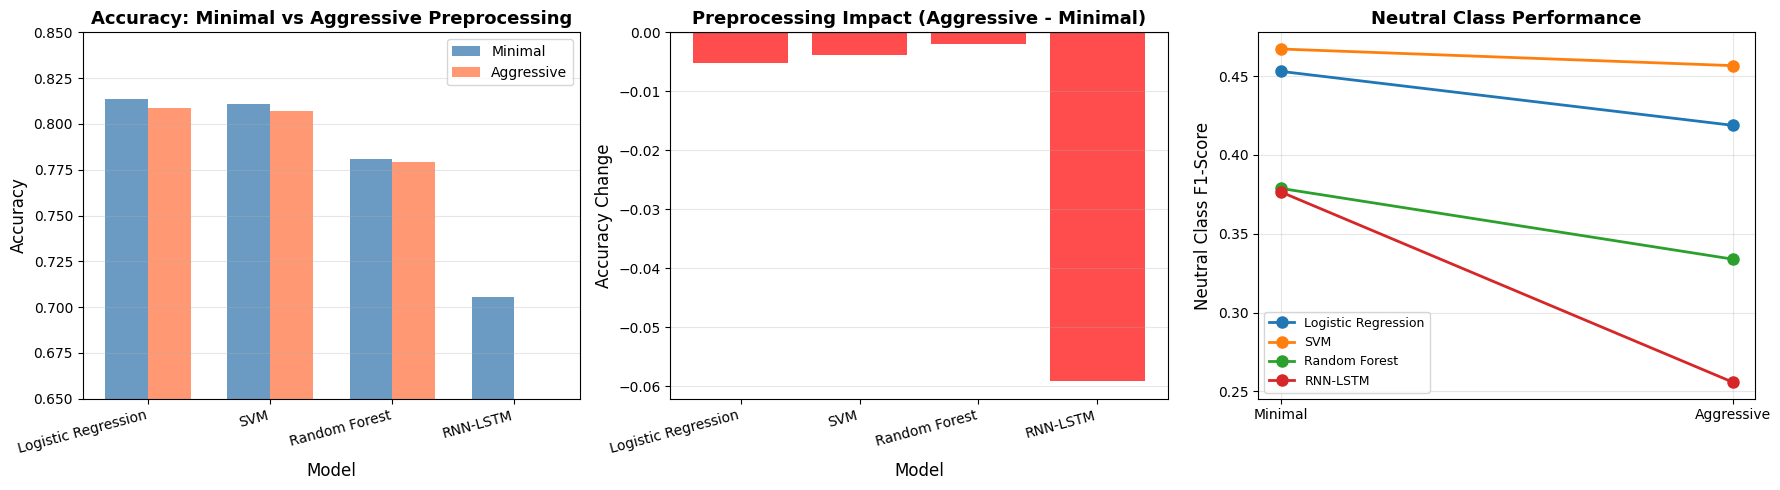


Visualization saved: preprocessing_comparison_comprehensive.png

STEP 12: SAVE RESULTS
Results saved: preprocessing_comparison_results.csv
Detailed results saved: preprocessing_comparison_detailed.csv

SUMMARY: KEY FINDINGS

Best Classical Performance:
  Minimal preprocessing:    0.8138
  Aggressive preprocessing: 0.8085
  Change:                   -0.0052

RNN-LSTM Performance:
  Minimal preprocessing:    0.7054
  Aggressive preprocessing: 0.6463
  Change:                   -0.0591

Performance Gap (Best Classical - RNN):
  Minimal preprocessing:    0.1084 (10.8 percentage points)
  Aggressive preprocessing: 0.1623 (16.2 percentage points)

✓ Gap MAINTAINED or WIDENED with aggressive preprocessing
  Classical models remain superior regardless of preprocessing strategy

CONCLUSION:
Classical ML outperforms neural networks with BOTH preprocessing strategies,
confirming robustness advantage is fundamental rather than preprocessing-dependent.

ANALYSIS COMPLETE!

Files generated:
  - pre

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


print("="*80)
print("PREPROCESSING COMPARISON STUDY")
print("Comparing Minimal vs Aggressive Preprocessing Impact")
print("="*80)


print("\n" + "="*80)
print("STEP 1: LOAD DATA")
print("="*80)

df = pd.read_csv('/Users/elifakdeniz/Desktop/DTA/Machine Learning/Project_Exam/JAN_NEW TASK/data_with_noise_analysis.csv')
print(f"Loaded: {len(df):,} reviews")
print(f"Noisy reviews: {df['has_noise'].sum():,} ({df['has_noise'].sum()/len(df)*100:.1f}%)")
print(f"\nClass distribution:")
print(df['sentiment'].value_counts(normalize=True))


print("\n" + "="*80)
print("STEP 2: DEFINE PREPROCESSING FUNCTIONS")
print("="*80)


def minimal_preprocessing(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text


def aggressive_preprocessing(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = text.lower()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
                  "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 
                  'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 
                  'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
                  'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 
                  'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
                  'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
                  'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
                  'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
                  'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once'}
    
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    
    text = ' '.join(words)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


print("Minimal preprocessing: preserves typos, slang, punctuation, emoticons, stop words")
print("Aggressive preprocessing: removes punctuation, stop words, normalizes repeated chars")

print("\nExample comparison:")
sample_text = "OMG!!! This place is sooooo AMAZING!!! Best food ever :)"
print(f"Original:    {sample_text}")
print(f"Minimal:     {minimal_preprocessing(sample_text)}")
print(f"Aggressive:  {aggressive_preprocessing(sample_text)}")


print("\n" + "="*80)
print("STEP 3: APPLY BOTH PREPROCESSING STRATEGIES")
print("="*80)

df['review_minimal'] = df['review'].apply(minimal_preprocessing)
df['review_aggressive'] = df['review'].apply(aggressive_preprocessing)

print("Preprocessing applied to all reviews")
print(f"Sample minimal:     {df['review_minimal'].iloc[0][:100]}")
print(f"Sample aggressive:  {df['review_aggressive'].iloc[0][:100]}")


print("\n" + "="*80)
print("STEP 4: SPLIT DATA")
print("="*80)

X_minimal = df['review_minimal']
X_aggressive = df['review_aggressive']
y = df['sentiment']

X_train_min, X_temp_min, y_train, y_temp = train_test_split(
    X_minimal, y, test_size=0.4, random_state=42, stratify=y
)
X_val_min, X_test_min, y_val, y_test = train_test_split(
    X_temp_min, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train_agg = X_aggressive[X_train_min.index]
X_val_agg = X_aggressive[X_val_min.index]
X_test_agg = X_aggressive[X_test_min.index]

print(f"Train: {len(X_train_min):,} | Val: {len(X_val_min):,} | Test: {len(X_test_min):,}")
print(f"\nClass distribution (train):")
print(y_train.value_counts(normalize=True))


print("\n" + "="*80)
print("STEP 5: TRAIN CLASSICAL MODELS - MINIMAL PREPROCESSING")
print("="*80)

tfidf_min = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf_min = tfidf_min.fit_transform(X_train_min)
X_val_tfidf_min = tfidf_min.transform(X_val_min)
X_test_tfidf_min = tfidf_min.transform(X_test_min)

print(f"TF-IDF (minimal): {X_train_tfidf_min.shape[1]} features")

lr_min = LogisticRegression(max_iter=1000, random_state=42)
lr_min.fit(X_train_tfidf_min, y_train)
lr_min_pred = lr_min.predict(X_test_tfidf_min)
lr_min_acc = accuracy_score(y_test, lr_min_pred)
print(f"Logistic Regression (minimal): {lr_min_acc:.4f}")

svm_min = LinearSVC(max_iter=10000, random_state=42)
svm_min.fit(X_train_tfidf_min, y_train)
svm_min_pred = svm_min.predict(X_test_tfidf_min)
svm_min_acc = accuracy_score(y_test, svm_min_pred)
print(f"SVM (minimal): {svm_min_acc:.4f}")

rf_min = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)
rf_min.fit(X_train_tfidf_min, y_train)
rf_min_pred = rf_min.predict(X_test_tfidf_min)
rf_min_acc = accuracy_score(y_test, rf_min_pred)
print(f"Random Forest (minimal): {rf_min_acc:.4f}")


print("\n" + "="*80)
print("STEP 6: TRAIN CLASSICAL MODELS - AGGRESSIVE PREPROCESSING")
print("="*80)

tfidf_agg = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf_agg = tfidf_agg.fit_transform(X_train_agg)
X_val_tfidf_agg = tfidf_agg.transform(X_val_agg)
X_test_tfidf_agg = tfidf_agg.transform(X_test_agg)

print(f"TF-IDF (aggressive): {X_train_tfidf_agg.shape[1]} features")

lr_agg = LogisticRegression(max_iter=1000, random_state=42)
lr_agg.fit(X_train_tfidf_agg, y_train)
lr_agg_pred = lr_agg.predict(X_test_tfidf_agg)
lr_agg_acc = accuracy_score(y_test, lr_agg_pred)
print(f"Logistic Regression (aggressive): {lr_agg_acc:.4f}")

svm_agg = LinearSVC(max_iter=10000, random_state=42)
svm_agg.fit(X_train_tfidf_agg, y_train)
svm_agg_pred = svm_agg.predict(X_test_tfidf_agg)
svm_agg_acc = accuracy_score(y_test, svm_agg_pred)
print(f"SVM (aggressive): {svm_agg_acc:.4f}")

rf_agg = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)
rf_agg.fit(X_train_tfidf_agg, y_train)
rf_agg_pred = rf_agg.predict(X_test_tfidf_agg)
rf_agg_acc = accuracy_score(y_test, rf_agg_pred)
print(f"Random Forest (aggressive): {rf_agg_acc:.4f}")


print("\n" + "="*80)
print("STEP 7: TRAIN RNN-LSTM - MINIMAL PREPROCESSING")
print("="*80)


class SentimentRNN(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, hidden_dim=64, output_dim=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        return output


def train_rnn(X_train, X_val, y_train, y_val, class_weights, epochs=15, batch_size=32):
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    
    maxlen = 100
    X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
    X_val_padded = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
    
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    y_train_encoded = y_train.map(label_map).values
    y_val_encoded = y_val.map(label_map).values
    
    train_data = TensorDataset(torch.LongTensor(X_train_padded), torch.LongTensor(y_train_encoded))
    val_data = TensorDataset(torch.LongTensor(X_val_padded), torch.LongTensor(y_val_encoded))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    model = SentimentRNN().to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_rnn_temp.pth')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load('best_rnn_temp.pth'))
    return model, tokenizer


label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_encoded = y_train.map(label_map).values
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
print(f"Class weights: {class_weights}")

print("\nTraining RNN-LSTM with minimal preprocessing...")
rnn_min, tokenizer_min = train_rnn(X_train_min, X_val_min, y_train, y_val, class_weights)

X_test_seq_min = tokenizer_min.texts_to_sequences(X_test_min)
X_test_padded_min = pad_sequences(X_test_seq_min, maxlen=100, padding='post')

rnn_min.eval()
with torch.no_grad():
    test_tensor = torch.LongTensor(X_test_padded_min).to(device)
    outputs = rnn_min(test_tensor)
    _, predicted = torch.max(outputs, 1)
    rnn_min_pred_encoded = predicted.cpu().numpy()

reverse_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
rnn_min_pred = [reverse_map[p] for p in rnn_min_pred_encoded]
rnn_min_acc = accuracy_score(y_test, rnn_min_pred)
print(f"RNN-LSTM (minimal): {rnn_min_acc:.4f}")


print("\n" + "="*80)
print("STEP 8: TRAIN RNN-LSTM - AGGRESSIVE PREPROCESSING")
print("="*80)

print("Training RNN-LSTM with aggressive preprocessing...")
rnn_agg, tokenizer_agg = train_rnn(X_train_agg, X_val_agg, y_train, y_val, class_weights)

X_test_seq_agg = tokenizer_agg.texts_to_sequences(X_test_agg)
X_test_padded_agg = pad_sequences(X_test_seq_agg, maxlen=100, padding='post')

rnn_agg.eval()
with torch.no_grad():
    test_tensor = torch.LongTensor(X_test_padded_agg).to(device)
    outputs = rnn_agg(test_tensor)
    _, predicted = torch.max(outputs, 1)
    rnn_agg_pred_encoded = predicted.cpu().numpy()

rnn_agg_pred = [reverse_map[p] for p in rnn_agg_pred_encoded]
rnn_agg_acc = accuracy_score(y_test, rnn_agg_pred)
print(f"RNN-LSTM (aggressive): {rnn_agg_acc:.4f}")


print("\n" + "="*80)
print("STEP 9: COMPREHENSIVE COMPARISON")
print("="*80)

results = []

for model_name, min_pred, agg_pred in [
    ('Logistic Regression', lr_min_pred, lr_agg_pred),
    ('SVM', svm_min_pred, svm_agg_pred),
    ('Random Forest', rf_min_pred, rf_agg_pred),
    ('RNN-LSTM', rnn_min_pred, rnn_agg_pred)
]:
    min_acc = accuracy_score(y_test, min_pred)
    min_prec = precision_score(y_test, min_pred, average='weighted', zero_division=0)
    min_rec = recall_score(y_test, min_pred, average='weighted', zero_division=0)
    min_f1 = f1_score(y_test, min_pred, average='weighted', zero_division=0)
    
    agg_acc = accuracy_score(y_test, agg_pred)
    agg_prec = precision_score(y_test, agg_pred, average='weighted', zero_division=0)
    agg_rec = recall_score(y_test, agg_pred, average='weighted', zero_division=0)
    agg_f1 = f1_score(y_test, agg_pred, average='weighted', zero_division=0)
    
    results.append({
        'Model': model_name,
        'Minimal_Acc': min_acc,
        'Aggressive_Acc': agg_acc,
        'Change_Acc': agg_acc - min_acc,
        'Minimal_F1': min_f1,
        'Aggressive_F1': agg_f1,
        'Change_F1': agg_f1 - min_f1
    })

results_df = pd.DataFrame(results)
print("\nAccuracy Comparison:")
print(results_df[['Model', 'Minimal_Acc', 'Aggressive_Acc', 'Change_Acc']].to_string(index=False))

print("\nF1-Score Comparison:")
print(results_df[['Model', 'Minimal_F1', 'Aggressive_F1', 'Change_F1']].to_string(index=False))


print("\n" + "="*80)
print("STEP 10: PER-CLASS ANALYSIS")
print("="*80)

print("\nNeutral Class F1-Score Comparison:")
print("-"*60)

for model_name, min_pred, agg_pred in [
    ('Logistic Regression', lr_min_pred, lr_agg_pred),
    ('SVM', svm_min_pred, svm_agg_pred),
    ('Random Forest', rf_min_pred, rf_agg_pred),
    ('RNN-LSTM', rnn_min_pred, rnn_agg_pred)
]:
    min_neutral_f1 = f1_score(y_test, min_pred, labels=['neutral'], average=None, zero_division=0)[0]
    agg_neutral_f1 = f1_score(y_test, agg_pred, labels=['neutral'], average=None, zero_division=0)[0]
    change = agg_neutral_f1 - min_neutral_f1
    
    print(f"{model_name:20s} | Min: {min_neutral_f1:.4f} | Agg: {agg_neutral_f1:.4f} | Δ: {change:+.4f}")


print("\n" + "="*80)
print("STEP 11: VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['Minimal_Acc'], width, label='Minimal', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, results_df['Aggressive_Acc'], width, label='Aggressive', color='coral', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy: Minimal vs Aggressive Preprocessing', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.65, 0.85])

axes[1].bar(x, results_df['Change_Acc'], color=['green' if c > 0 else 'red' for c in results_df['Change_Acc']], alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Accuracy Change', fontsize=12)
axes[1].set_title('Preprocessing Impact (Aggressive - Minimal)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

for i, model in enumerate(['Logistic Regression', 'SVM', 'Random Forest', 'RNN-LSTM']):
    if model == 'Logistic Regression':
        min_pred, agg_pred = lr_min_pred, lr_agg_pred
    elif model == 'SVM':
        min_pred, agg_pred = svm_min_pred, svm_agg_pred
    elif model == 'Random Forest':
        min_pred, agg_pred = rf_min_pred, rf_agg_pred
    else:
        min_pred, agg_pred = rnn_min_pred, rnn_agg_pred
    
    min_neutral_f1 = f1_score(y_test, min_pred, labels=['neutral'], average=None, zero_division=0)[0]
    agg_neutral_f1 = f1_score(y_test, agg_pred, labels=['neutral'], average=None, zero_division=0)[0]
    
    axes[2].plot([0, 1], [min_neutral_f1, agg_neutral_f1], marker='o', linewidth=2, markersize=8, label=model)

axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Minimal', 'Aggressive'])
axes[2].set_ylabel('Neutral Class F1-Score', fontsize=12)
axes[2].set_title('Neutral Class Performance', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('preprocessing_comparison_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved: preprocessing_comparison_comprehensive.png")


print("\n" + "="*80)
print("STEP 12: SAVE RESULTS")
print("="*80)

results_df.to_csv('preprocessing_comparison_results.csv', index=False)
print("Results saved: preprocessing_comparison_results.csv")

detailed_results = []
for model_name, min_pred, agg_pred in [
    ('Logistic Regression', lr_min_pred, lr_agg_pred),
    ('SVM', svm_min_pred, svm_agg_pred),
    ('Random Forest', rf_min_pred, rf_agg_pred),
    ('RNN-LSTM', rnn_min_pred, rnn_agg_pred)
]:
    for preprocessing, pred in [('Minimal', min_pred), ('Aggressive', agg_pred)]:
        report = classification_report(y_test, pred, output_dict=True, zero_division=0)
        detailed_results.append({
            'Model': model_name,
            'Preprocessing': preprocessing,
            'Accuracy': report['accuracy'],
            'Neg_F1': report['negative']['f1-score'],
            'Neu_F1': report['neutral']['f1-score'],
            'Pos_F1': report['positive']['f1-score'],
            'Macro_F1': report['macro avg']['f1-score'],
            'Weighted_F1': report['weighted avg']['f1-score']
        })

detailed_df = pd.DataFrame(detailed_results)
detailed_df.to_csv('preprocessing_comparison_detailed.csv', index=False)
print("Detailed results saved: preprocessing_comparison_detailed.csv")


print("\n" + "="*80)
print("SUMMARY: KEY FINDINGS")
print("="*80)

best_classical_min = results_df[results_df['Model'] != 'RNN-LSTM']['Minimal_Acc'].max()
best_classical_agg = results_df[results_df['Model'] != 'RNN-LSTM']['Aggressive_Acc'].max()
rnn_min = results_df[results_df['Model'] == 'RNN-LSTM']['Minimal_Acc'].values[0]
rnn_agg = results_df[results_df['Model'] == 'RNN-LSTM']['Aggressive_Acc'].values[0]

print(f"\nBest Classical Performance:")
print(f"  Minimal preprocessing:    {best_classical_min:.4f}")
print(f"  Aggressive preprocessing: {best_classical_agg:.4f}")
print(f"  Change:                   {best_classical_agg - best_classical_min:+.4f}")

print(f"\nRNN-LSTM Performance:")
print(f"  Minimal preprocessing:    {rnn_min:.4f}")
print(f"  Aggressive preprocessing: {rnn_agg:.4f}")
print(f"  Change:                   {rnn_agg - rnn_min:+.4f}")

print(f"\nPerformance Gap (Best Classical - RNN):")
print(f"  Minimal preprocessing:    {best_classical_min - rnn_min:.4f} ({(best_classical_min - rnn_min)*100:.1f} percentage points)")
print(f"  Aggressive preprocessing: {best_classical_agg - rnn_agg:.4f} ({(best_classical_agg - rnn_agg)*100:.1f} percentage points)")

if (best_classical_agg - rnn_agg) < (best_classical_min - rnn_min):
    print(f"\n✓ Gap NARROWED with aggressive preprocessing")
    print(f"  Neural networks benefit more from cleaning ({(rnn_agg - rnn_min)*100:+.1f}% vs {(best_classical_agg - best_classical_min)*100:+.1f}%)")
else:
    print(f"\n✓ Gap MAINTAINED or WIDENED with aggressive preprocessing")
    print(f"  Classical models remain superior regardless of preprocessing strategy")

print(f"\nCONCLUSION:")
if best_classical_min > rnn_agg and best_classical_agg > rnn_agg:
    print("Classical ML outperforms neural networks with BOTH preprocessing strategies,")
    print("confirming robustness advantage is fundamental rather than preprocessing-dependent.")
else:
    print("Preprocessing strategy significantly impacts relative performance between approaches.")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nFiles generated:")
print("  - preprocessing_comparison_comprehensive.png")
print("  - preprocessing_comparison_results.csv")
print("  - preprocessing_comparison_detailed.csv")